In [1]:
import os
import scipy.misc
import numpy as np

from forward_model import DCGAN
from utils import pp, visualize, to_json, show_all_variables

import tensorflow as tf

from glob import glob
from ops import *
from utils import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#flags

flags = tf.app.flags
flags.DEFINE_integer("epoch", 15, "Epoch to train [20]") # changed to 20 from  25
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_integer("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", 16, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 256, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", 320, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 256, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", 320, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "train_img_slices", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("checkpoint_dir", "checkpoint", "Directory name to save the checkpoints [checkpoint]")
flags.DEFINE_string("sample_dir", "samples", "Directory name to save the image samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", True, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
FLAGS = flags.FLAGS

pp.pprint(flags.FLAGS.__flags)

if FLAGS.input_width is None:
    FLAGS.input_width = FLAGS.input_height
if FLAGS.output_width is None:
    FLAGS.output_width = FLAGS.output_height

if not os.path.exists(FLAGS.checkpoint_dir):
    os.makedirs(FLAGS.checkpoint_dir)
if not os.path.exists(FLAGS.sample_dir):
    os.makedirs(FLAGS.sample_dir)

#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth=True

{}


In [3]:
data = glob("./data/train_img_slices/*.ra")


sample_files = data[0:16]
sample = [get_image(sample_file,
                    input_height=256,
                    input_width=320,
                    resize_height=256,
                    resize_width=320,
                    crop=False,
                    grayscale=True) for sample_file in sample_files]

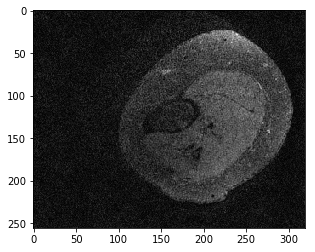

In [4]:
plt.imshow(sample[0], cmap ='gray')
plt.show()

In [5]:
v = np.reshape(sample, (16, 256*320))
# number of features per image (pixels including all channels)
print('shape of v: {}'.format(v.shape))


n = v.shape[1]

shape of v: (16, 81920)


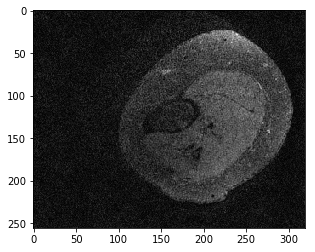

 [*] Reading checkpoints...
Instructions for updating:
Please use tf.global_variables instead.
z:0
generator/g_h0_lin/Matrix:0
generator/g_h0_lin/bias:0
generator/g_bn0/beta:0
generator/g_bn0/gamma:0
generator/g_bn0/moving_mean:0
generator/g_bn0/moving_variance:0
generator/g_h1/w:0
generator/g_h1/biases:0
generator/g_bn1/beta:0
generator/g_bn1/gamma:0
generator/g_bn1/moving_mean:0
generator/g_bn1/moving_variance:0
generator/g_h2/w:0
generator/g_h2/biases:0
generator/g_bn2/beta:0
generator/g_bn2/gamma:0
generator/g_bn2/moving_mean:0
generator/g_bn2/moving_variance:0
generator/g_h3/w:0
generator/g_h3/biases:0
generator/g_bn3/beta:0
generator/g_bn3/gamma:0
generator/g_bn3/moving_mean:0
generator/g_bn3/moving_variance:0
generator/g_h4/w:0
generator/g_h4/biases:0
discriminator/d_h0_conv/w:0
discriminator/d_h0_conv/biases:0
discriminator/d_h1_conv/w:0
discriminator/d_h1_conv/biases:0
discriminator/d_bn1/beta:0
discriminator/d_bn1/gamma:0
discriminator/d_bn1/moving_mean:0
discriminator/d_bn1/

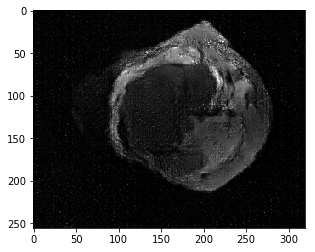

number of measurements = 500
iteration 0
6117.59


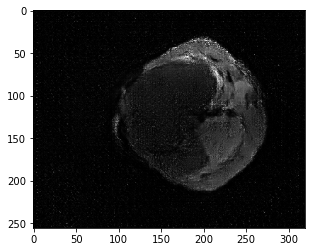

number of measurements = 1000
iteration 0
5169.68


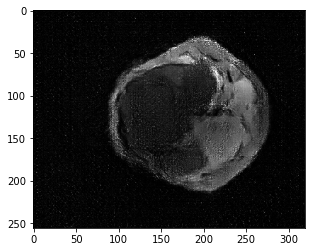

number of measurements = 2000
iteration 0
4437.37


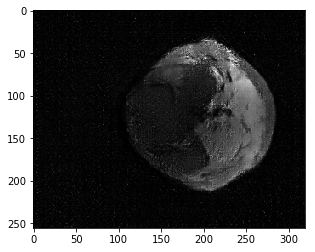

number of measurements = 5000
iteration 0
4197.88


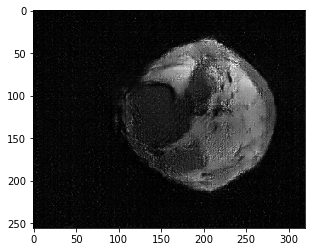

number of measurements = 6000
iteration 0
3797.08


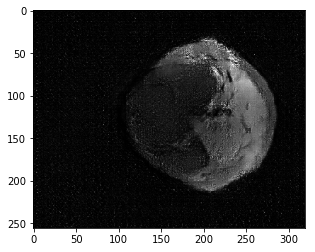

In [6]:
possible_ms = [100, 500, 1000, 2000, 5000, 6000]
num_iter = 250
compressed_images = []

plt.imshow(sample[0], cmap='gray')
plt.show()


with tf.Session() as sess:

    #print(tf.global_variables())

    dcgan = DCGAN(
        sess,
        input_width=FLAGS.input_width,
        input_height=FLAGS.input_height,
        output_width=FLAGS.output_width,
        output_height=FLAGS.output_height,
        batch_size=FLAGS.batch_size,
        sample_num=FLAGS.batch_size,
        dataset_name=FLAGS.dataset,
        input_fname_pattern=FLAGS.input_fname_pattern,
        crop=FLAGS.crop,
        checkpoint_dir=FLAGS.checkpoint_dir,
        sample_dir=FLAGS.sample_dir)



    if not dcgan.load(FLAGS.checkpoint_dir)[0]:
        raise Exception("[!] Train a model first, then run test mode")

    dcgan.z.initializer.run()

    for m in possible_ms:
        A = np.random.randn(n, m).astype('float32')
        A = A / np.sqrt( np.sum( A**2, axis = 1 ) )[:,None]
        y = np.dot(v, A) 

        print('number of measurements = {}'.format(m))
        count = 0
        y_placeholder = tf.placeholder(tf.float32,[None,m])

        # -----------------------------------
        our_loss = tf.reduce_mean( tf.reduce_sum( (tf.matmul(tf.reshape(dcgan.G, [16, -1]) , A) - y_placeholder)**2, 1)) 
        # -----------------------------------

        z_optim = tf.train.AdamOptimizer(learning_rate=0.1).minimize(our_loss, var_list=dcgan.z)  

        opt_initializers   = [var.initializer for var in tf.global_variables() if 'Adam' in var.name]
        beta1_initializers = [var.initializer for var in tf.global_variables() if 'beta1_power' in var.name]
        beta2_initializers = [var.initializer for var in tf.global_variables() if 'beta2_power' in var.name]

        sess.run(opt_initializers)
        sess.run(beta1_initializers)
        sess.run(beta2_initializers)


        for i in range(num_iter): 
            print('iteration {}'.format(count))
            a, closs, b = sess.run([z_optim, our_loss, dcgan.G],feed_dict={y_placeholder: y})
            count += 1
            print(closs)
        plt.imshow(b[0].reshape((256, 320)), cmap='gray')
        compressed_images.append(b)
        plt.show()

    

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


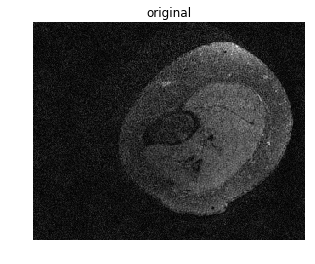

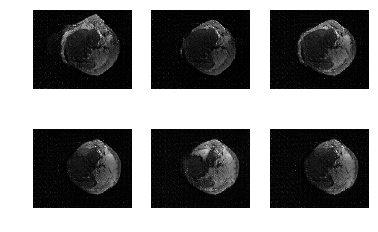

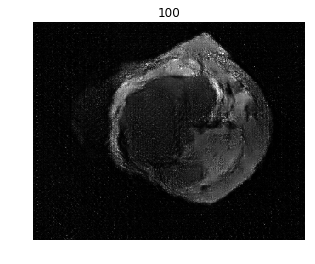

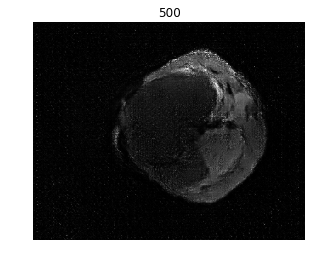

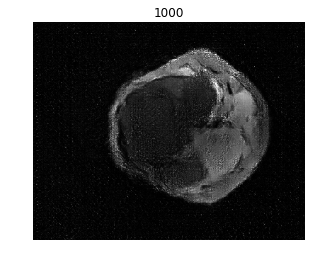

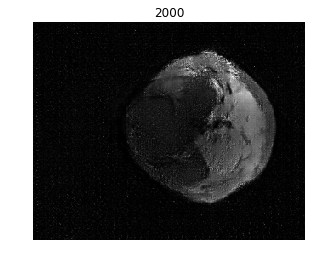

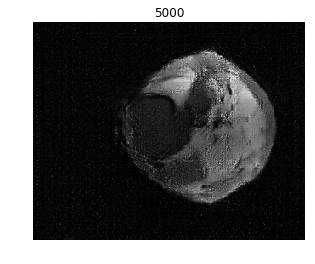

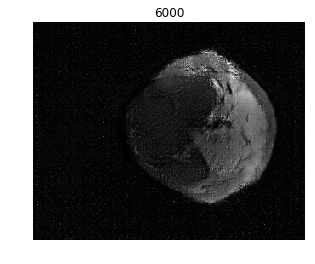

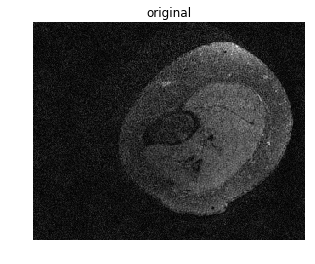

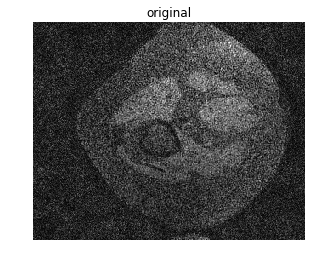

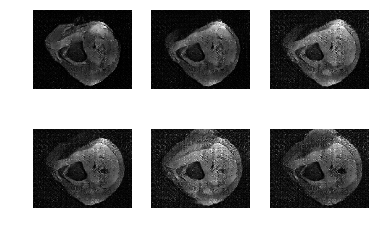

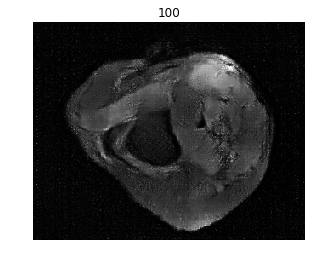

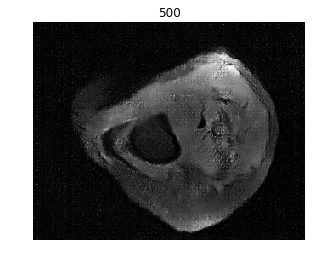

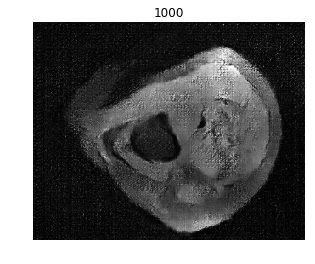

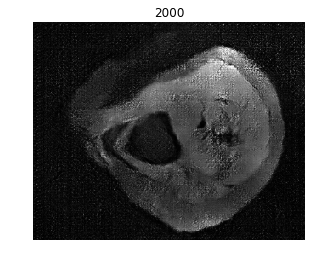

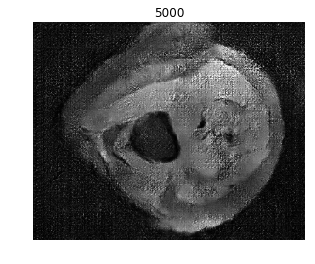

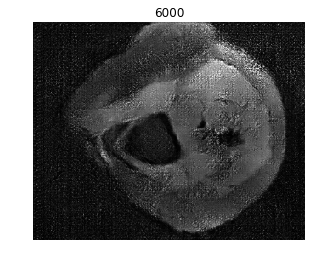

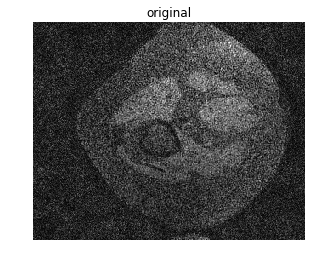

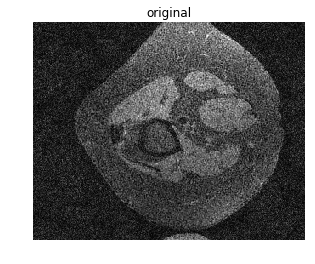

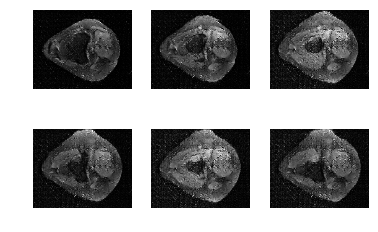

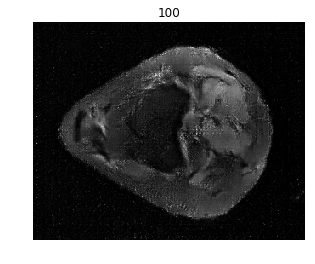

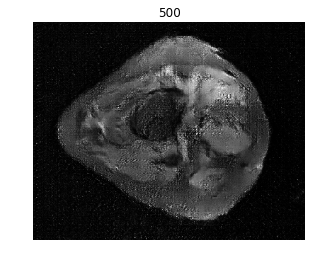

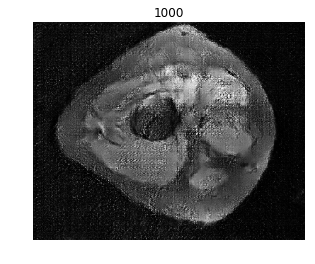

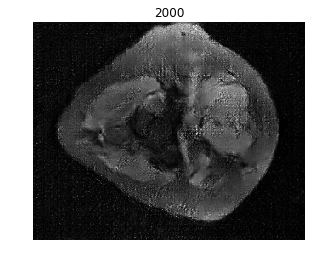

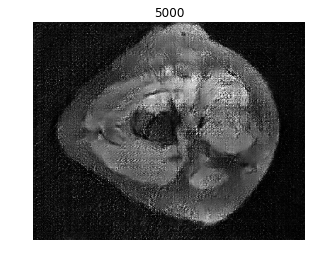

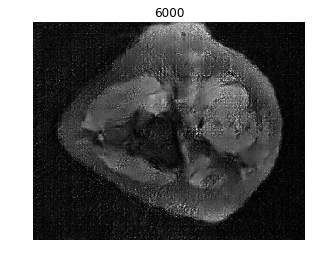

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


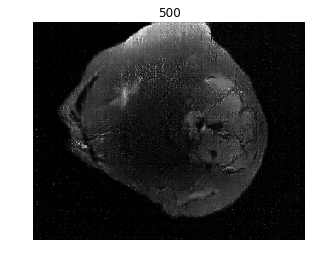

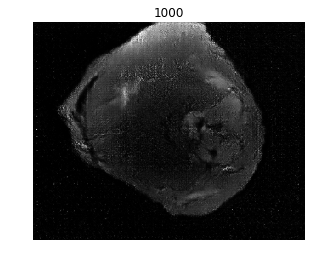

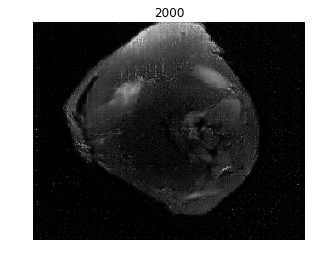

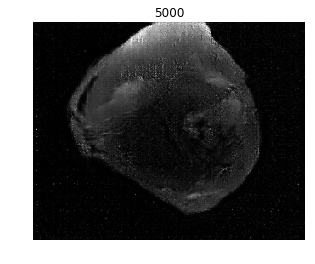

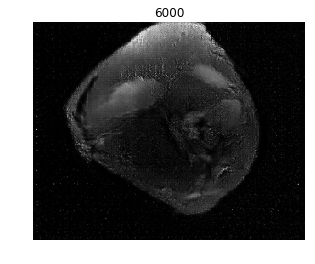

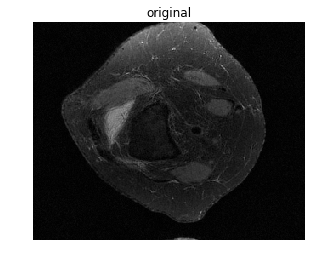

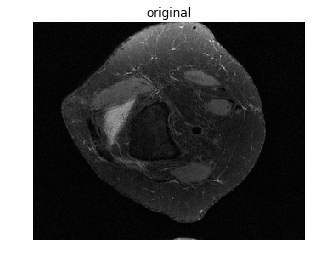

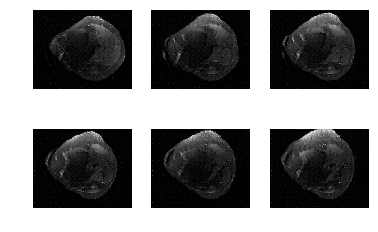

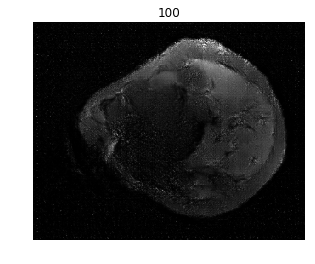

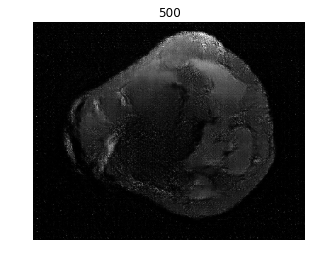

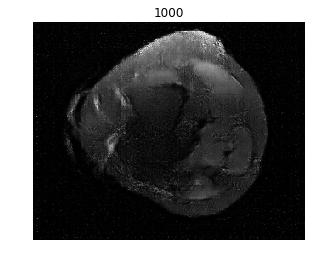

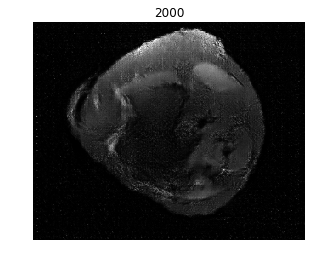

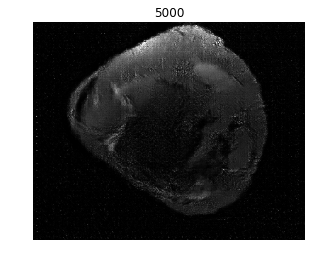

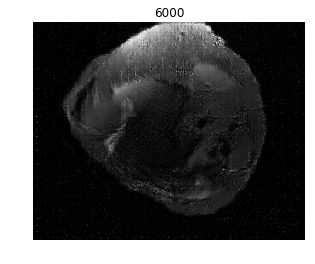

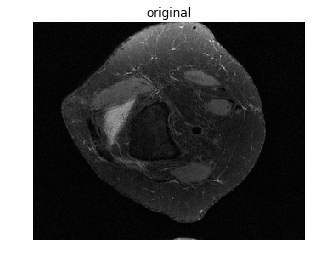

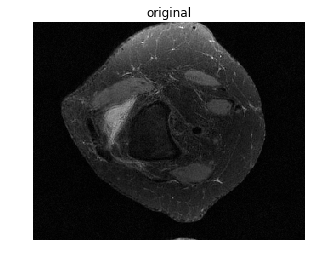

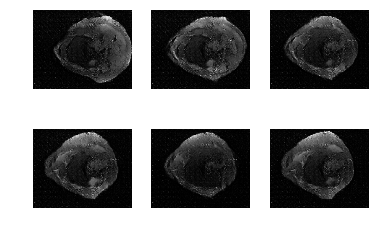

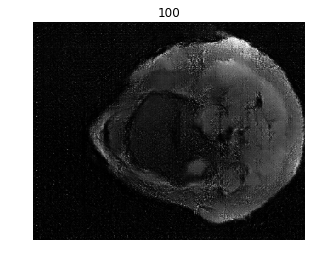

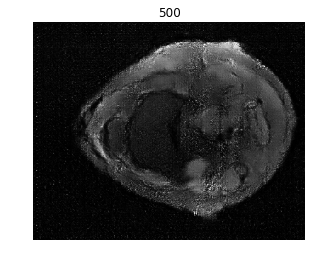

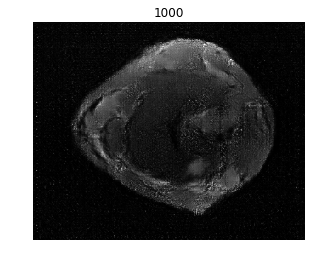

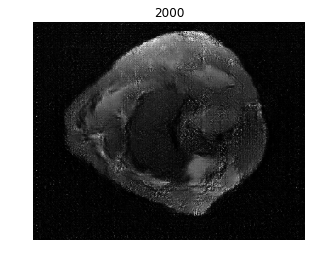

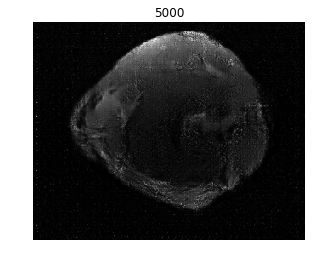

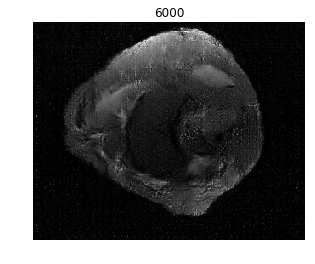

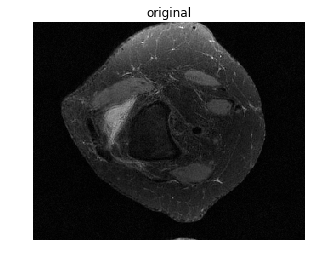

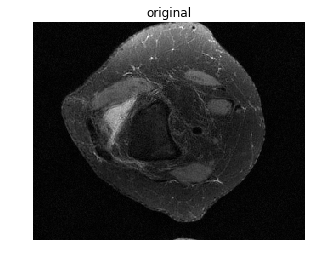

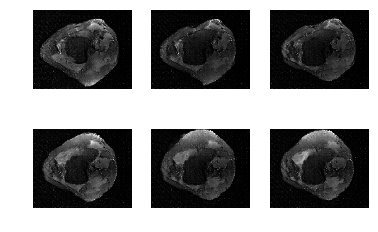

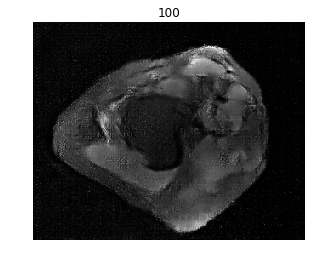

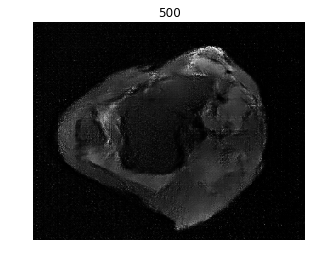

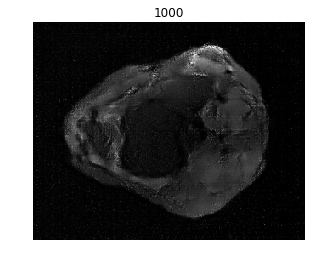

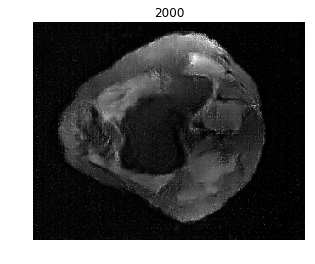

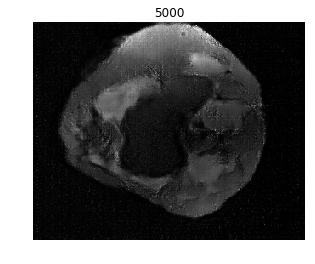

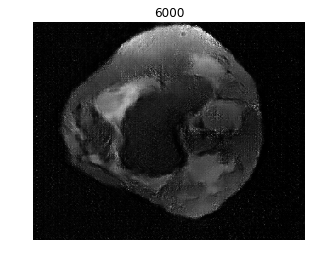

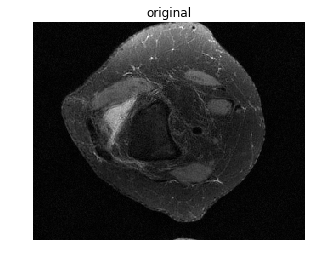

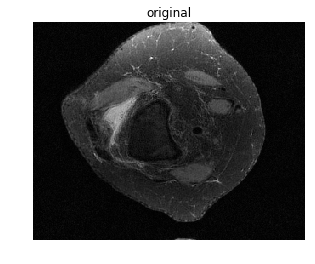

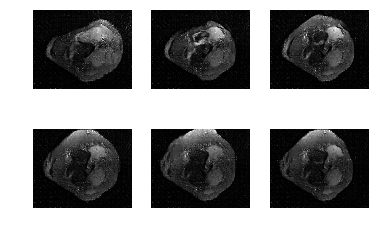

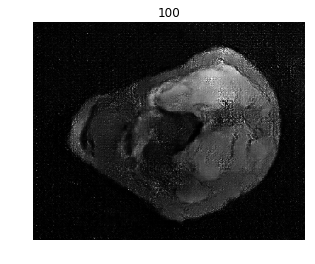

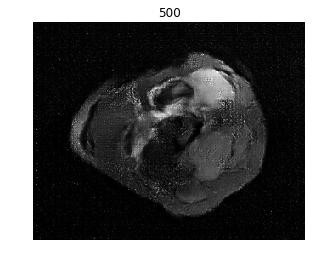

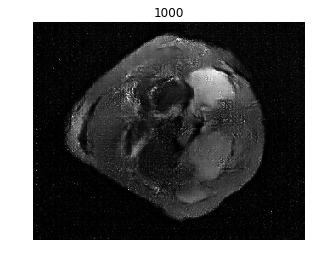

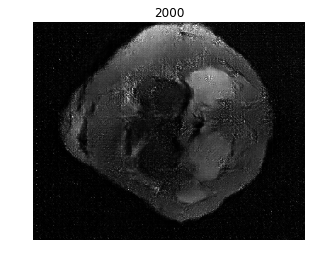

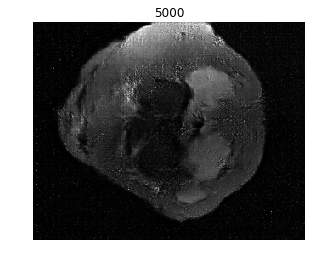

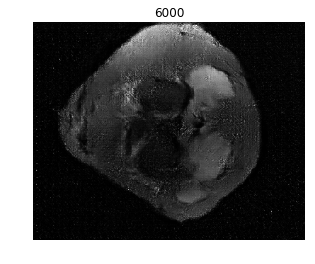

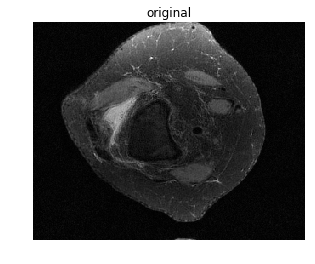

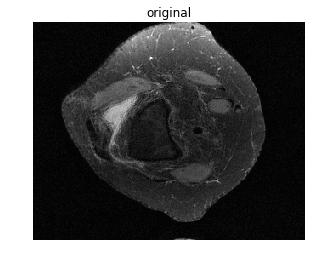

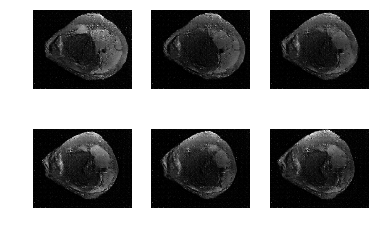

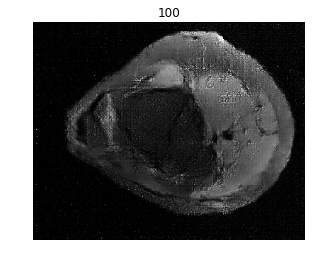

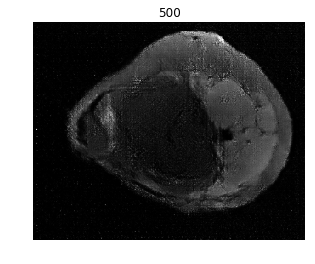

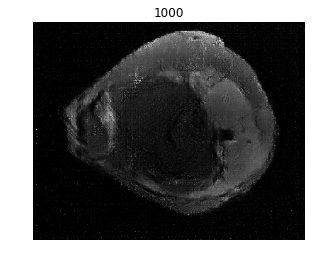

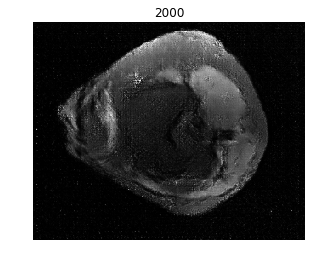

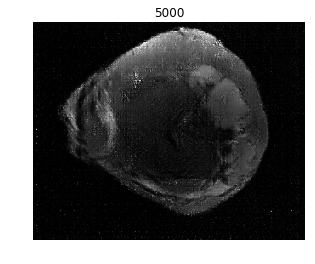

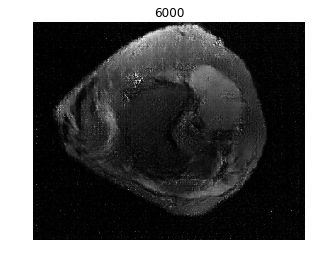

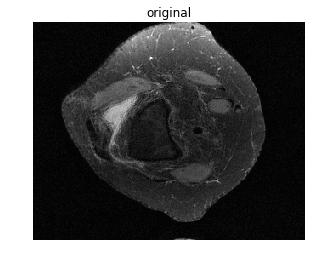

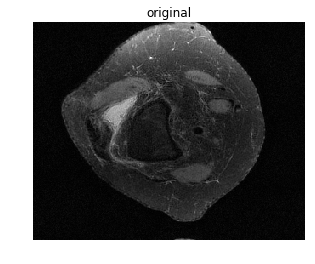

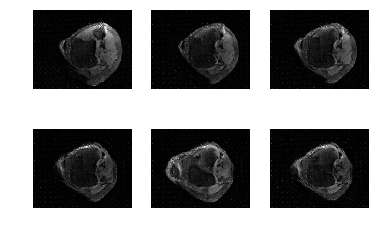

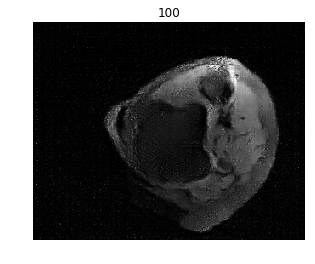

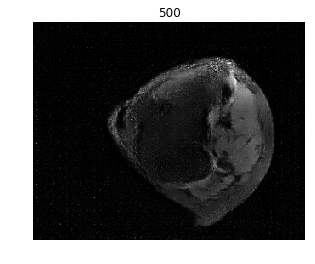

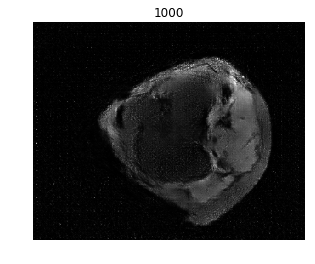

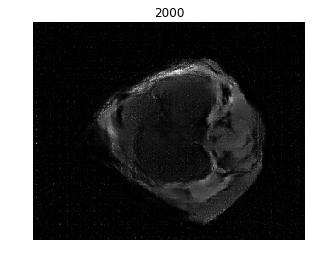

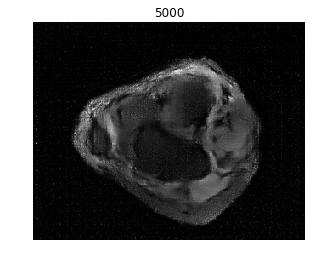

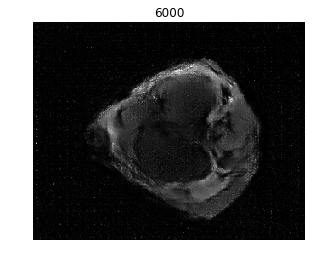

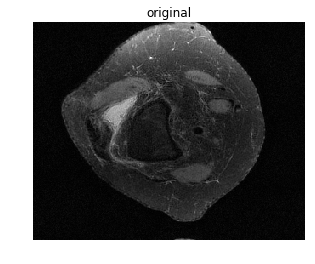

In [7]:
errors = []
for image_num in range(10):
    meas_err = []
    plt.figure()
    plt.title("original")
    plt.imshow(sample[image_num], cmap='gray') 
    plt.axis('off')

    fig = plt.figure()
    for i in range(len(compressed_images)):
        im = fig.add_subplot(2, len(compressed_images) / 2, i + 1)
        plt.imshow((compressed_images[i][image_num].reshape((256, 320))), cmap = 'gray')
        plt.axis('off')
        meas_err.append(np.sum((sample[image_num] - compressed_images[i][image_num].reshape((256, 320)))**2))
    #print(meas_err)
    errors.append(meas_err)

    for i in range(len(compressed_images)):
        plt.figure()
        plt.title(possible_ms[i])
        plt.imshow((compressed_images[i][image_num].reshape((256, 320))), cmap='gray')
        plt.axis('off')
        plt.figure()
    plt.title("original")
    plt.imshow(sample[image_num], cmap='gray') 
    plt.axis('off')

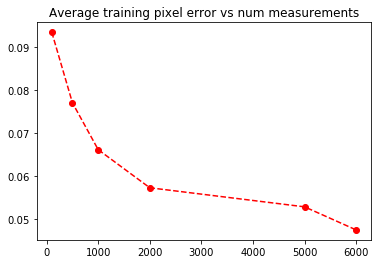

In [8]:
plt.plot(possible_ms, np.mean(errors, axis=0) / (256.0*320.0), '--ro')
plt.title("Average training pixel error vs num measurements")
plt.show()